<a href="https://colab.research.google.com/github/noahdenicola/RL/blob/main/NoahDeNicola_TSP_InstaDeep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r ../requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


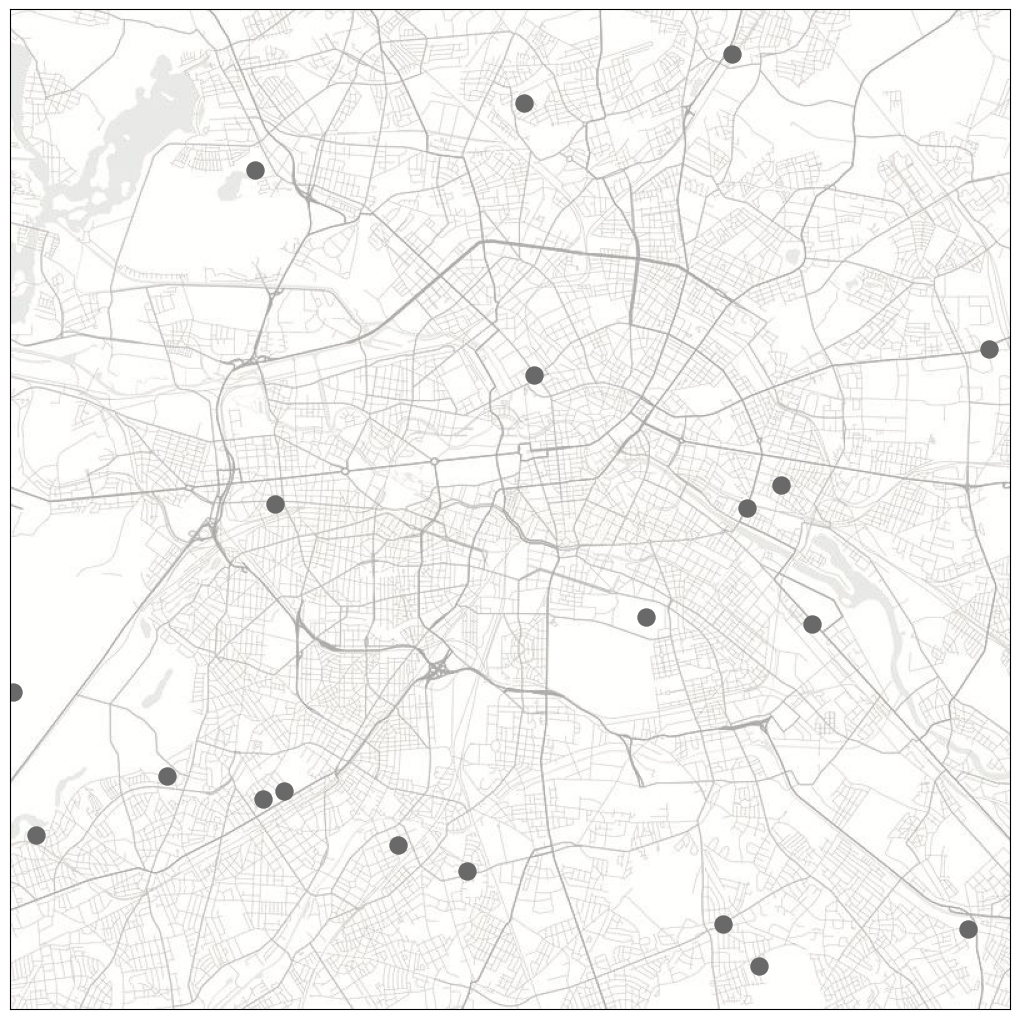

In [10]:
import jax
import jax.numpy as jnp
import numpy as np
import jumanji
import haiku as hk

from jax import value_and_grad

env = jumanji.make('TSP-v1')

# Reset your (jit-able) environment
key = jax.random.PRNGKey(0)
state, timestep = jax.jit(env.reset)(key)

# (Optional) Render the env state
env.render(state)

# Interact with the (jit-able) environment
action = env.action_spec().generate_value()          # Action selection (dummy value here)
state, timestep = jax.jit(env.step)(state, 1) 


In [28]:
#Get Key
rng = jax.random.PRNGKey(42)

#Defn Class
class Network(hk.Module):
  def __init__(self, hidden_size=64, output_size=1, name='QNet'):
    super().__init__(name=name)
    self.mlp = hk.nets.MLP(output_sizes=[hidden_size, output_size])

  def __call__(self, x):
    return self.mlp(x)

#FeedForward Method
def ff(x):
  module = Network()
  return module(x)

#Initialise Model
model = hk.transform(ff)
params = model.init(rng, jnp.array([[1., 2., 3., 4.]]))

for layer_name, weights in params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(params[layer_name]["w"].shape,params[layer_name]["b"].shape))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


QNet/~/mlp/~/linear_0
Weights : (4, 64), Biases : (64,)

QNet/~/mlp/~/linear_1
Weights : (64, 1), Biases : (1,)



In [30]:
#Training Methods
def MSE(params, x, y):
  y_hat = model.apply(params, rng, x)
  y_hat = y_hat.squeeze()
  return jnp.power(y-y_hat, 2).mean()

def step(params, grads):
  return params - lr*grads

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, Y = datasets.load_iris(return_X_y=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=123)

X_train, X_test, Y_train, Y_test = jnp.array(X_train, dtype=jnp.float32),\
                                   jnp.array(X_test, dtype=jnp.float32),\
                                   jnp.array(Y_train, dtype=jnp.float32),\
                                   jnp.array(Y_test, dtype=jnp.float32),\

samples, features = X_train.shape

X = X_train
Y = Y_train

print(X.shape, Y.shape)


(120, 4) (120,)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
#Training Loop
epochs = 300
lr = 1e-3

for i in range(epochs):
  loss, grads = value_and_grad(MSE)(params, X, Y)
  params = jax.tree_map(step, params, grads)

  if i%50 == 0:
        print("MSE : {:.2f}".format(loss))

MSE : 5.14
MSE : 0.15
MSE : 0.07
MSE : 0.06
MSE : 0.06
MSE : 0.06
